# 0. Load data and dependencies

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
import scipy.signal as sp
from scipy.interpolate import griddata
import os
import warnings
from scipy.special import iv
from scipy.optimize import curve_fit
import matplotlib
from interstellar import *
import itertools

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')

# Set path to dataframe directory
df_dir = "../../data/dataframes/"

In [121]:
def activity_heatmap(ax_data, g, degs_lim = 8, vmax=1.5, stim_radius = 0, colors = ['b', 'o', 'g'], titles = [], 
                     cmap = 'RdBu_r', plot = True, plot_stim_circle = False, eccen_restrict = 0):
    n_steps = len(np.arange(-degs_lim, degs_lim, 0.125))
    
    for k, d in enumerate(ax_data):
        ax = g.axes.flatten()[k]
        
        ax_heatmap = np.reshape(d, (n_steps, n_steps))

        if eccen_restrict:
            radius = eccen_restrict
            fov = degs_lim*2
            unit_size = fov / ax_heatmap.shape[0]
            for i, j in itertools.product(range(ax_heatmap.shape[0]), range(ax_heatmap.shape[1])):
                i_val =  (i - ax_heatmap.shape[0]/2) * unit_size
                j_val =  (j - ax_heatmap.shape[1]/2) * unit_size

                if np.sqrt(i_val**2 + j_val**2) <= radius:
                    ax_heatmap[i, j] = 0

        
        if plot:
            sns.heatmap(ax_heatmap, cbar=False, square=True, cmap=cmap, 
                        vmin=-1*vmax, vmax=vmax, linewidths=0, cbar_kws={'ticks':[]}, ax=ax)
            ax.invert_yaxis()
            #ax.set(xlim=[-4, 132], ylim=[-4, 132])
            ax.set_xticklabels(labels=[], rotation=0)
            ax.set_yticklabels(labels=[])
            ax.axhline(y=n_steps/2, c="0")
            ax.axvline(x=n_steps/2, c="0")
            ax.text(n_steps+8, n_steps/2, "$\it{x}$", ha='left', va='center', color="0", size=12)
            ax.text(n_steps/2, -20, "$\it{y}$", ha='center', va='bottom', color="0", size=12)

            ax.set_title(titles[k].title())
            if plot_stim_circle:
                circle2 = plt.Circle((n_steps/2, n_steps/2), n_steps/2 * (stim_radius/degs_lim), color=colors[k], fill=False, lw = 2)
                ax.add_patch(circle2)
    
    if plot:
        sns.despine(trim=True, left=True, bottom=True)
        plt.gcf().tight_layout(h_pad=3)

    return ax_heatmap
    
    
def stim_activity_figure(interp_data, vmax=[1.5, 1.5], degs_lim = 8):
    dplot = interp_data.groupby(['stim_angle', 'sacc', 'inds'])['activity_map'].aggregate(np.nanmedian).reset_index()
    with sns.axes_style("white"):
        g = sns.FacetGrid(col = 'stim_angle', height = 3, aspect = 1, sharex=False, data = interp_data)
        
    ax_data = []

    for i, d in g.facet_data():
        s, a = d[['sacc', 'stim_angle']].iloc[0]
        ax_data.append(dplot.query("sacc==@s & stim_angle==@a")['activity_map'].values)

    
    activity_heatmap(ax_data, g, degs_lim = degs_lim, vmax=vmax)
    
    return ax_data
    

def fwhm(X, Y):
    d = Y - (max(Y) / 2) 
    indexes = np.where(d > 0)[0] 
    return abs(X[indexes[-1]] - X[indexes[0]])


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    
    return(rho, phi)


def pol2cart(rho, phi):    
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    
    return(x, y)



def fix_deg(x):
    x = x - np.floor(x / 360 + 0.5) * 360
    
    return x


def load_conds(pos_dir, wlsubj):
    pos_filepath = os.path.join(pos_dir, "sub-wlsubj%03d_16pos.tsv" % wlsubj)
    conds = pd.read_csv(pos_filepath, sep = "\t", index_col = 0)
    
    return conds



def convert_angle(x):
    if x < 0: x += 360
    
    return x


center_bin = lambda x: (x.left.astype(float) + x.right.astype(float))/2
def vonmises(theta, loc, kappa, scale):
    p = scale * np.exp(kappa*np.cos(theta-loc))/(2*np.pi*iv(0,kappa))
    return p


def diff_vonmises(theta, loc, kappa1, scale1, kappa2, scale2):
    p1 = vonmises(theta, loc, kappa1, scale1)
    p2 = vonmises(theta, loc, kappa2, scale2)
    return (p1 - p2) 


def fwhm(X, Y):
    d = Y - (np.max(Y) / 2) 
    indexes = np.where(d > 0)[0] 
    return abs(X[indexes[-1]] - X[indexes[0]])


def bin_ang_dists(voxels, angles, conds, stim_ecc = 0, subj = ''):
    df = pd.DataFrame(columns = ['subj', 'roi', 'cond', 'stim_angle', 'ang_dist', 'ang_dist_bin', 'beta', 'vexpl'])
    # Restrict Eccentricit
    if stim_ecc:
        voxels = voxels[np.abs(stim_ecc - voxels.eccen) <= voxels.sigma]
    
    # Concatenate betas by position's distance from target stims
    for i, angle in enumerate(angles):
        if not subj:
            subj = voxels['subj']
            
        df = df.append(
            pd.DataFrame(
                {'subj': subj,
                 'roi': voxels['surf_label'],
                 'ang_dist': voxels['dist_cond%02d' % i], 
                 'beta': voxels['cond%02d' % i],
                 'vexpl': voxels['vexpl'],
                 'cond': conds[i],
                 'stim_angle': angle,
                }
            ))
        
    # Bin these distances
    dist_bins = np.arange(-180, 220, 20) - 10
    bins = pd.cut(df['ang_dist'], bins=dist_bins)
    bins = bins.apply(center_bin).astype(float)
    bins[bins == -180.0] = 180.0
    df['ang_dist_bin'] = bins
    
    return df


def interpolate_activity(data, basis = 'cartesian', normalize = False, offset = 0, yval = 'beta', method = 'linear'):
    # Define stim space grid
    minval, maxval, stepval = [-degs_lim, degs_lim, .125]
    x, y = np.mgrid[minval:maxval:stepval, minval:maxval:stepval]
    
    # Polar
    thetaminval, thetamaxval, thetastepval = [-np.pi, np.pi, .0328]
    rhominval, rhomaxval, rhostepval = [0, degs_lim, 0.125/2]
    py, px = np.mgrid[thetaminval:thetamaxval:thetastepval, rhominval:rhomaxval:rhostepval]
    
    # Log Polar
    lthetaminval, lthetamaxval, lthetastepval = [-np.pi, np.pi, .0328]
    lrhominval, lrhomaxval, lrhostepval = [0, np.log(degs_lim+0.0001), np.log(degs_lim+0.0001)/192]
    ly, lx = np.mgrid[lthetaminval:lthetamaxval:lthetastepval, lrhominval:lrhomaxval:lrhostepval]
    
    
    ang_dists_rads = np.radians(data.target_dist + offset)
    rot_x, rot_y = pol2cart(data.eccen, ang_dists_rads)
    
    data['rot_x'] = rot_x.values
    data['rot_y'] = rot_y.values
    data['theta'] = ang_dists_rads
    data['rho'] = data.eccen
    data['lrho'] = np.log(data.eccen+0.0001)
    
    if basis == 'cartesian':
        pts = data[['x', 'y']].values
        vals = data[yval].values
        sinterp = griddata(pts, vals, (x, y), method = method, rescale = False).T

        pts = data[['rot_x', 'rot_y']].values
        vals = data[yval].values
        sinterp_rot = griddata(pts, vals, (x, y), method = method, rescale = False).T

    if normalize:
        sinterp = (sinterp - np.nanmean(sinterp)) / np.nanstd(sinterp)
        sinterp_rot = (sinterp_rot - np.nanmean(sinterp_rot)) / np.nanstd(sinterp_rot)
        
    sdf = pd.DataFrame(dict(
        # stim_angle = stim_angle, 
        activity_map=sinterp.flatten(), 
        activity_map_rot=sinterp_rot.flatten(), 
        task = data.task.unique()[0], 
        inds=np.arange(len(sinterp.flatten()))))
    
    return sdf.reset_index(drop = True), data


def avg_activity_figure(interp_data, vmax=1.5, degs_lim = 8, tasks = ['perception', 'ltm', 'wm'], 
                        colors = ['b', 'orange', 'g'], stim_radius = 0, cmap = 'RdBu_r', plot = True, eccen_restrict = 0):
    
    # Average across subjects 
    dplot = interp_data.groupby(['task', 'inds'])['activity_map_rot'].aggregate(np.nanmedian).reset_index()
    # Create axes and get data for each facet

    with sns.axes_style("white"):
        g = sns.FacetGrid(col='task', 
                         height=3, aspect=1, sharex=False, data=interp_data)
    ax_data = []
    i = 0
    
    for _, d in g.facet_data():
        s = tasks[i]
        i += 1
        ax_data.append(dplot[dplot.task == s]['activity_map_rot'].values)

        
    # Plot heatmap on each facet
    ax_heatmap = activity_heatmap(ax_data, g, degs_lim = degs_lim, 
                     vmax=vmax, stim_radius = stim_radius,
                     colors = colors, titles = tasks, cmap = cmap, plot = plot, eccen_restrict = eccen_restrict)
    
    return ax_heatmap
    
    
def get_angdist_bins(prevoxels, conds_by_trials, tasks, conds, angles, binsize = 20, query = ''):
    if query: prevoxels = prevoxels.query(query)

    voxels_by_stimangle = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl', 'roi',
           'surf_label'])

    voxel_dfs = {}

    for c in tqdm(conds):
        idx = np.where(conds_by_trials == c)[0]

        v = prevoxels.iloc[:, idx]
        v = v.mean(axis = 1)

        voxels_by_stimangle.insert(int(c), str(c), v)


    for t in tqdm(np.unique(tasks)):
        voxel_dfs[t] = prevoxels.filter(['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl',
           'surf_label', 'roi'])
        voxel_dfs[t]['task'] = t
        idx = np.where(tasks == t)[0]

        voxel_dfs[t] = voxel_dfs[t].merge(voxels_by_stimangle.iloc[:, idx], left_index = True, right_index = True)
        voxel_dfs[t] = voxel_dfs[t].melt(id_vars=['x', 'y', 'eccen', 'angle', 'sigma', 'vexpl', 'surf_label', 'task', 'roi'], 
            var_name="condition", 
            value_name="beta")

        stim_angle = angles[voxel_dfs[t].condition.values.astype(int)]

        theta = np.asarray([convert_angle(a) for a in np.degrees(voxel_dfs[t].angle)])
        target_dist = fix_deg(theta - stim_angle)

        voxel_dfs[t].insert(9, 'pref_angle', theta)
        voxel_dfs[t].insert(10, 'stim_angle', stim_angle)
        voxel_dfs[t].insert(11, 'target_dist', target_dist)

        # Bin these distances
        dist_bins = np.arange(-180, 220, 20) - 10
        bins = pd.cut(voxel_dfs[t]['target_dist'], bins=dist_bins)
        bins = bins.apply(center_bin).astype(float)
        bins[bins == -180.0] = 180.0
        voxel_dfs[t].insert(12, 'ang_dist_bin', bins)

        voxel_dfs[t].insert(0, 'subj', '%03d' % wlsubj)
        
    angdist_df = pd.concat(voxel_dfs)

    print("Done!")
    
    return angdist_df
    
    
def interpolate_activity(data, basis = 'cartesian', normalize = False, offset = 0, yval = 'beta'):
    # Define stim space grid
    minval, maxval, stepval = [-degs_lim, degs_lim, .125]
    x, y = np.mgrid[minval:maxval:stepval, minval:maxval:stepval]
    
#     # Polar
#     thetaminval, thetamaxval, thetastepval = [-np.pi, np.pi, .0328]
#     rhominval, rhomaxval, rhostepval = [0, degs_lim, 0.125/2]
#     py, px = np.mgrid[thetaminval:thetamaxval:thetastepval, rhominval:rhomaxval:rhostepval]
    
#     # Log Polar
#     lthetaminval, lthetamaxval, lthetastepval = [-np.pi, np.pi, .0328]
#     lrhominval, lrhomaxval, lrhostepval = [0, np.log(degs_lim+0.0001), np.log(degs_lim+0.0001)/192]
#     ly, lx = np.mgrid[lthetaminval:lthetamaxval:lthetastepval, lrhominval:lrhomaxval:lrhostepval]
    
    
    ang_dists_rads = np.radians(data.target_dist + offset)
    rot_x, rot_y = pol2cart(data.eccen, ang_dists_rads)
    
    data['rot_x'] = rot_x.values
    data['rot_y'] = rot_y.values
    data['theta'] = ang_dists_rads
    data['rho'] = data.eccen
    data['lrho'] = np.log(data.eccen+0.0001)
    
    if basis == 'cartesian':
        pts = data[['x', 'y']].values
        vals = data[yval].values
        sinterp = griddata(pts, vals, (x, y), method = 'linear', rescale = False).T

        pts = data[['rot_x', 'rot_y']].values
        vals = data[yval].values
        sinterp_rot = griddata(pts, vals, (x, y), method = 'linear', rescale = False).T

    if normalize:
        sinterp = (sinterp - np.nanmean(sinterp)) / np.nanstd(sinterp)
        sinterp_rot = (sinterp_rot - np.nanmean(sinterp_rot)) / np.nanstd(sinterp_rot)
        
    sdf = pd.DataFrame(dict(
        # stim_angle = stim_angle, 
        activity_map=sinterp.flatten(), 
        activity_map_rot=sinterp_rot.flatten(), 
        task = data.task.unique()[0], 
        inds=np.arange(len(sinterp.flatten()))))
    
    return sdf.reset_index(drop = True), data
        
    
def load_TTA(wlsubj, tta_dir, suffix = ''):
    fname = "sub-wlsubj%03d_TTA_%s" % (wlsubj, suffix)
    tta_path = os.path.join(tta_dir, "sub-wlsubj%03d" % wlsubj, fname)
    
    if not suffix:
        print("Must provide TTA file suffix. \nSome possible suffixes for desired wlsubj:\n------------------------------")
        possible_filenames = glob.glob(os.path.join(tta_dir, "sub-wlsubj%03d" % wlsubj, "*TTA*.tsv"))
        [print(i.split("/")[-1].split("sub-wlsubj%03d_TTA_" % wlsubj)[-1]) for i in possible_filenames]
        
    else:
        tta = pd.read_csv(tta_path, sep="\t", index_col = 0)
    
        return tta

Load example subject data.

In [122]:
angdist_df_subj127 = pd.read_csv(os.path.join(df_dir, 'angdist_df.tsv'), sep = '\t', index_col = 1)

# 1. Figure 3 
### Panel: Single-trial estimates in visual space

Plot single-trial estimates in visual space, averaged for each target position. From example subject 127. 

2.921165952319635


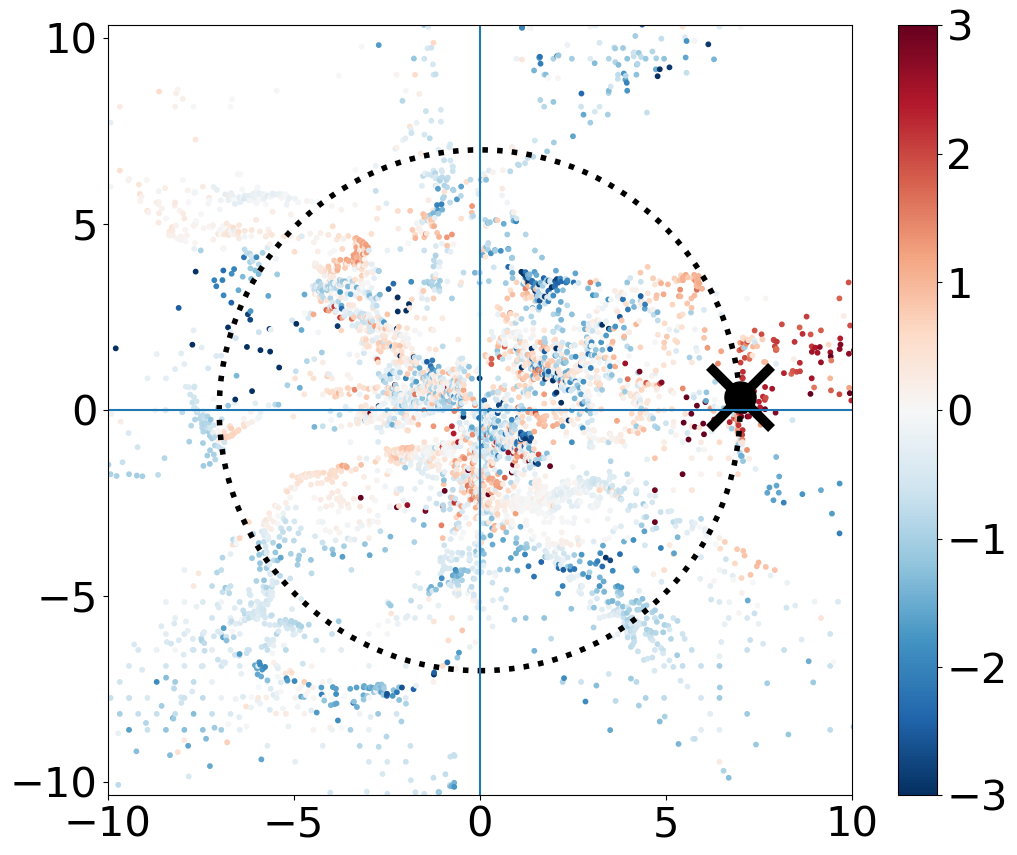

29.59570196798727


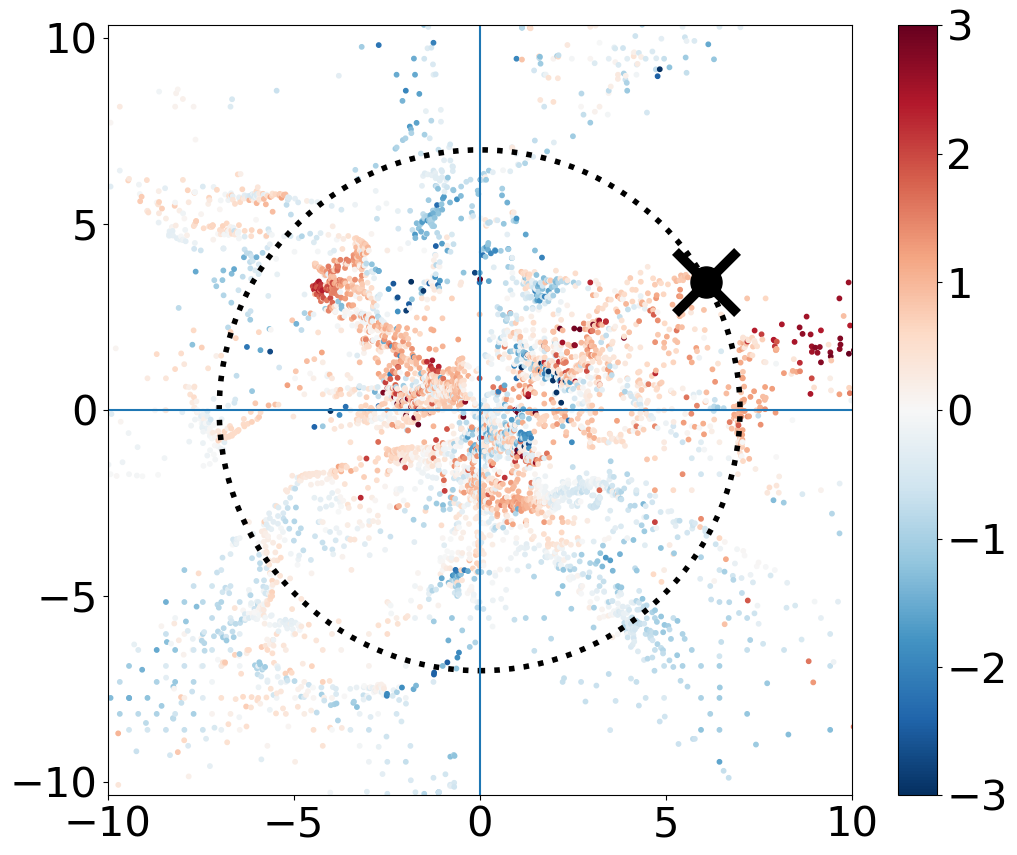

56.18287298716252


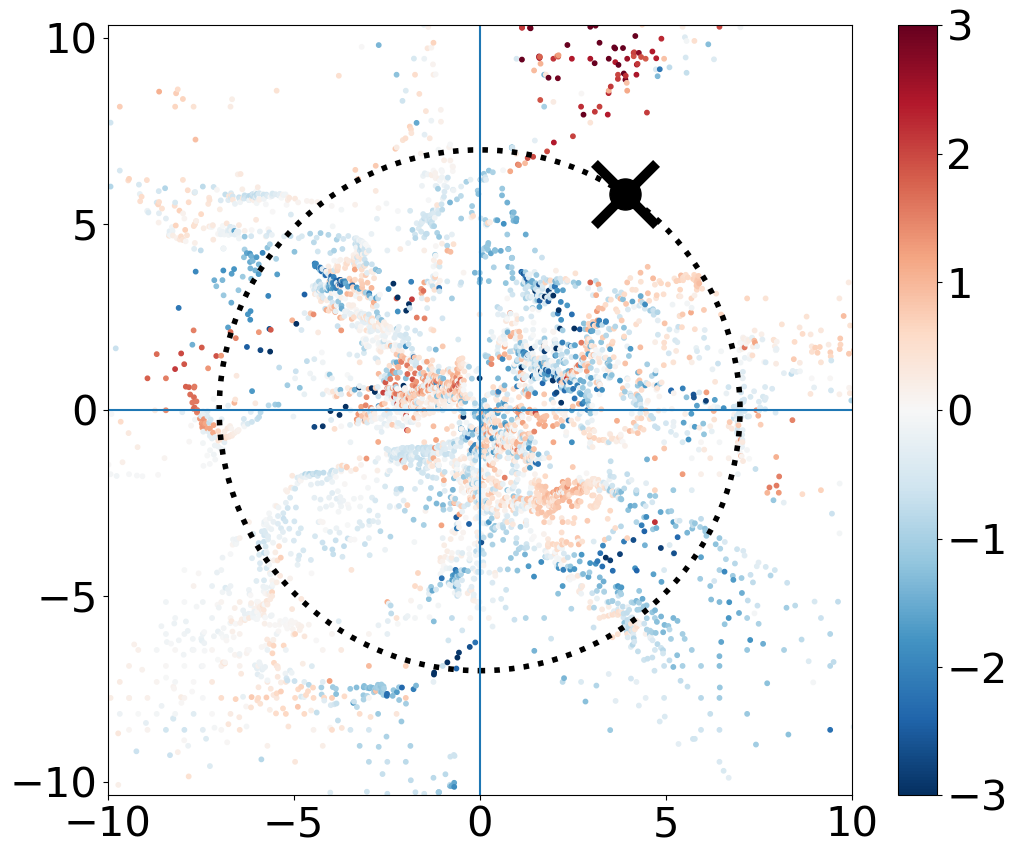

69.91613537476717


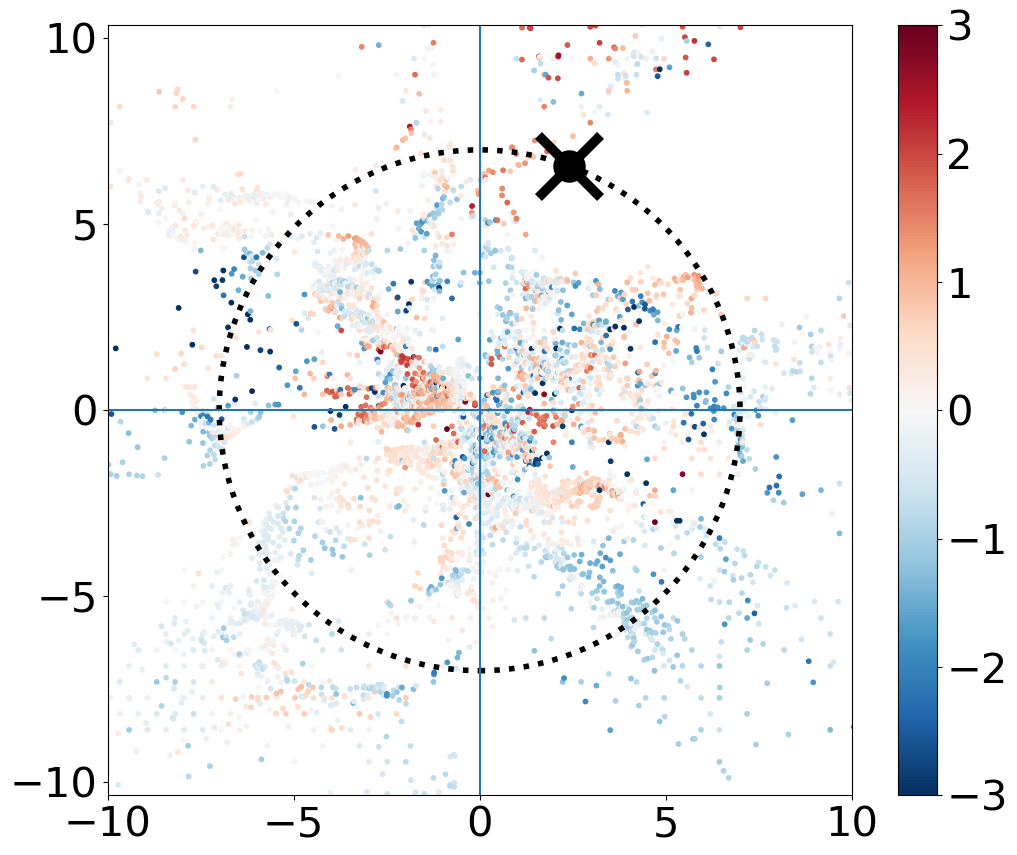

92.96311021723004


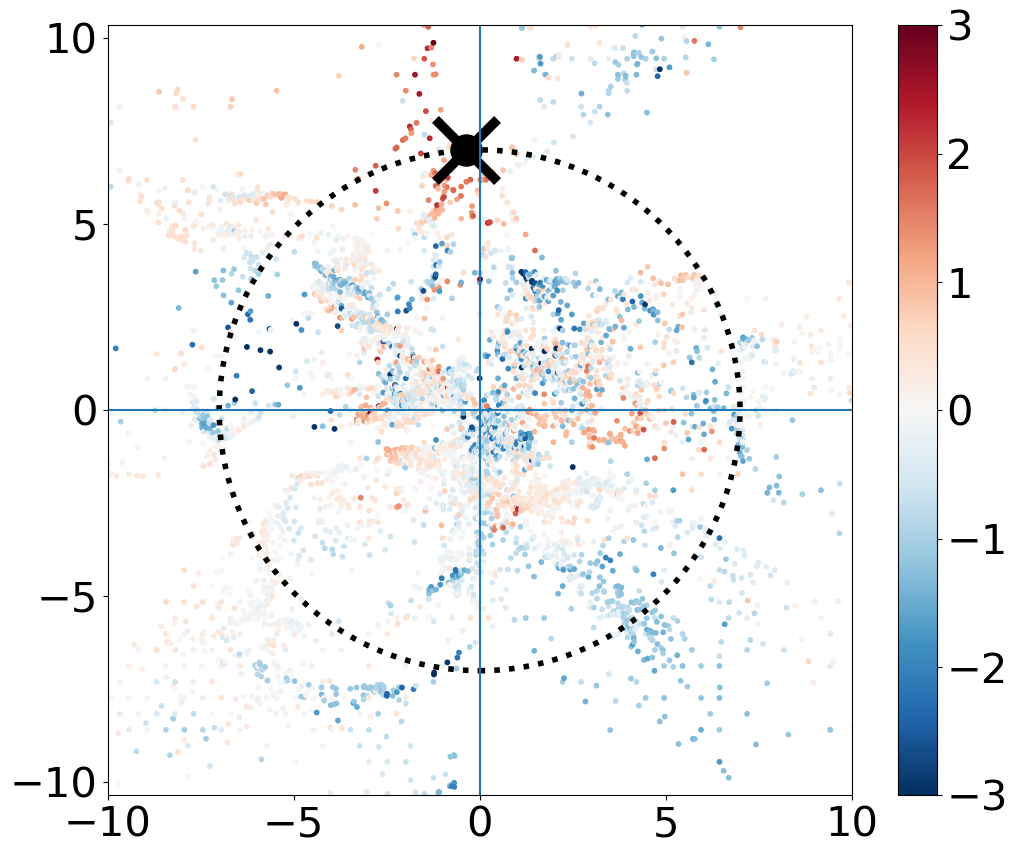

127.43006509517878


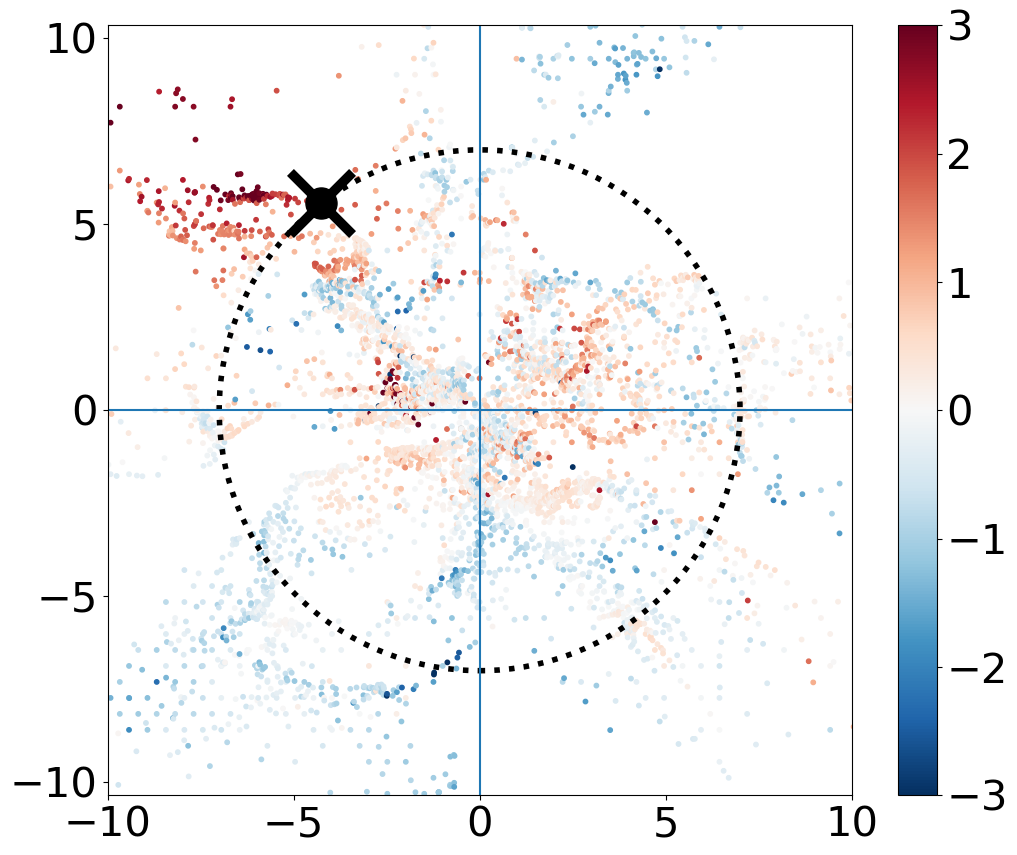

149.74081519249256


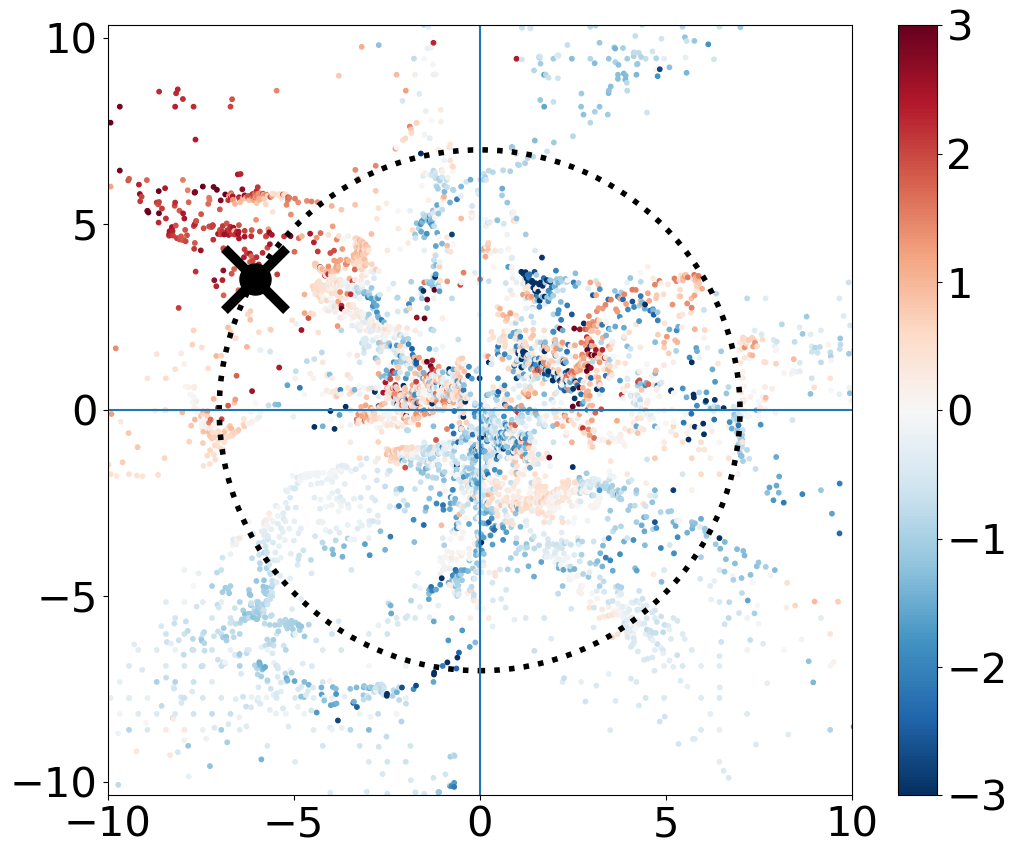

164.9995066599353


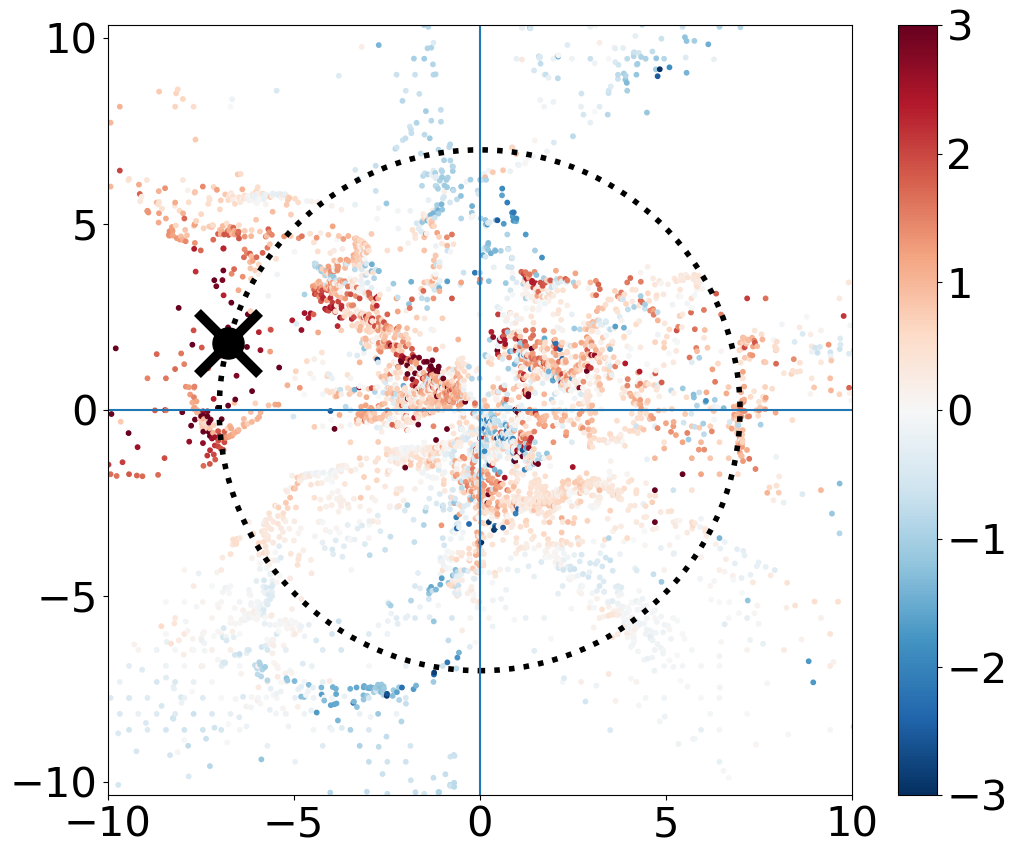

195.095205462141


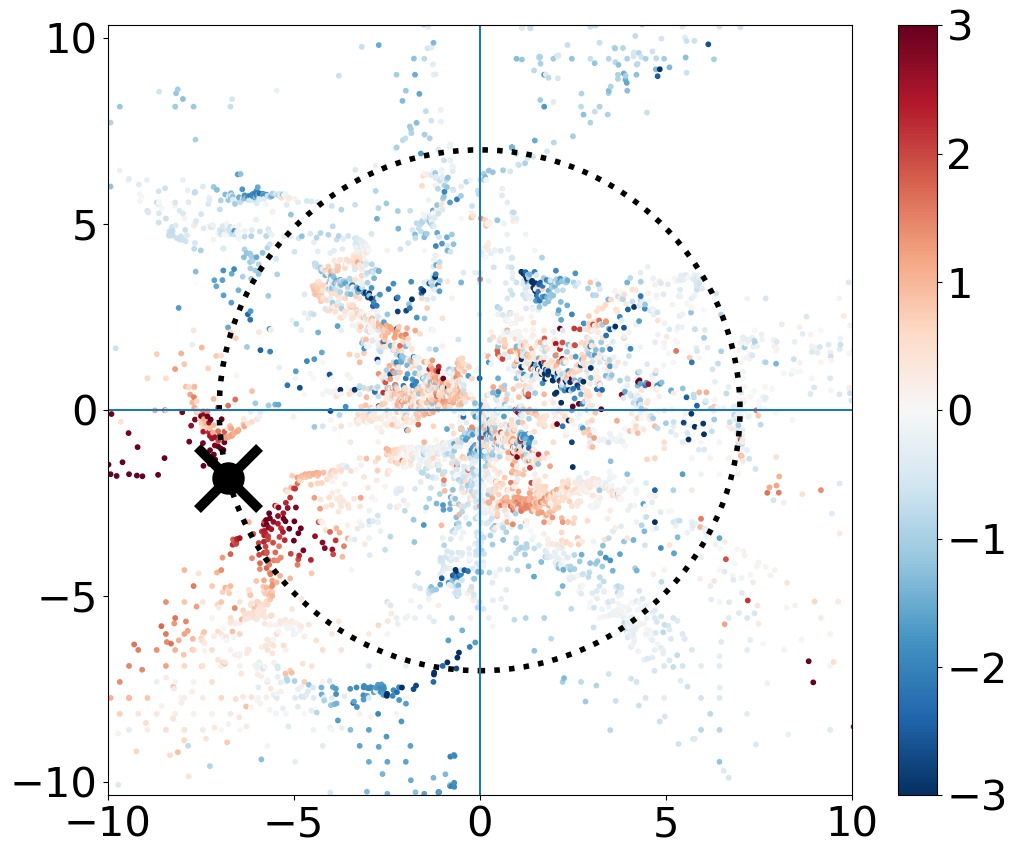

215.27587562174892


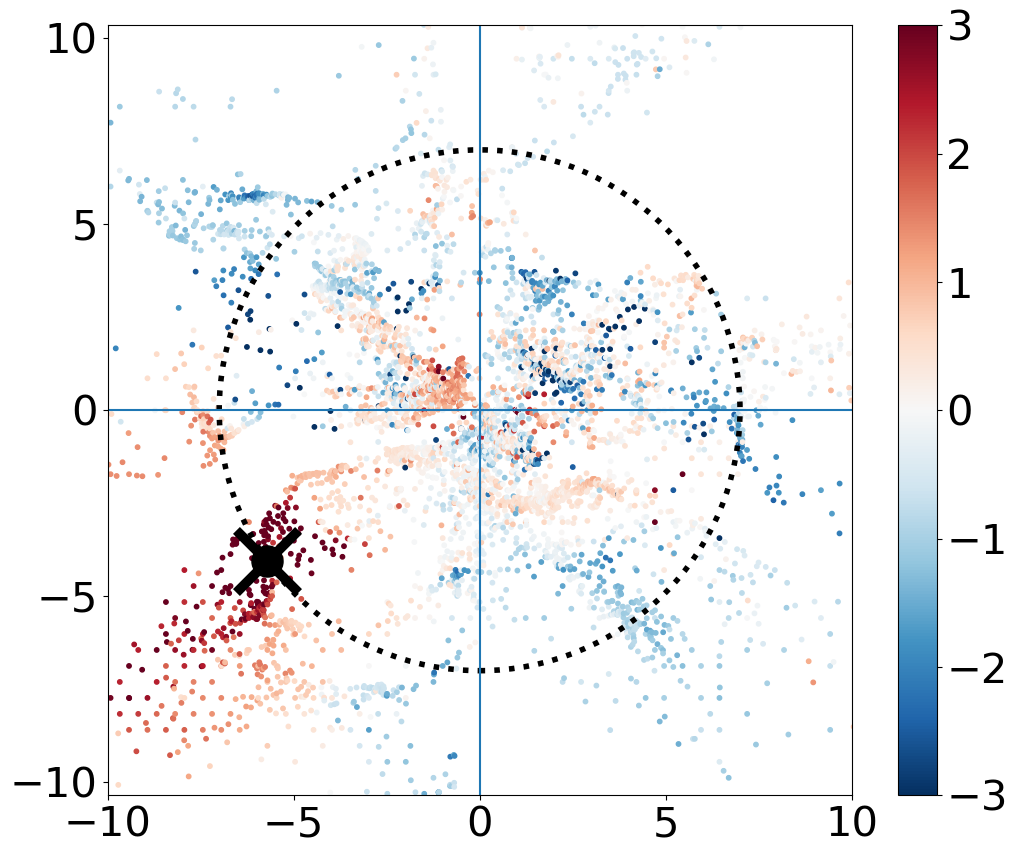

245.02711222952465


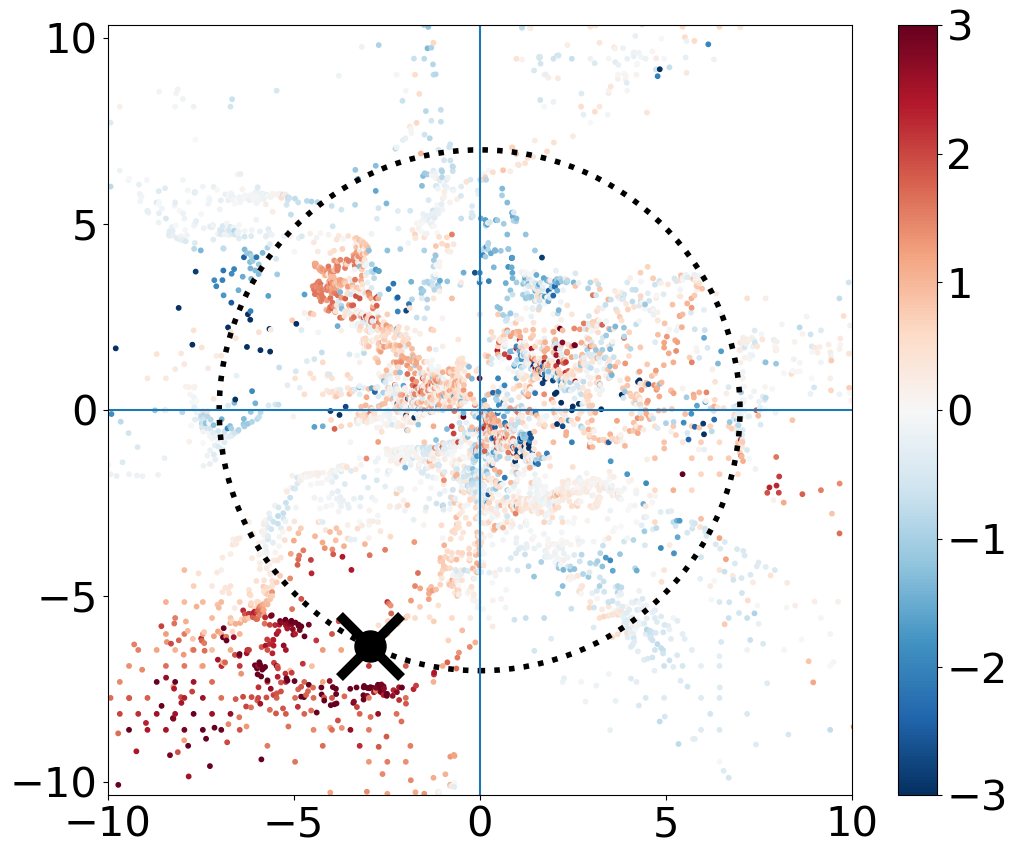

267.2623963943326


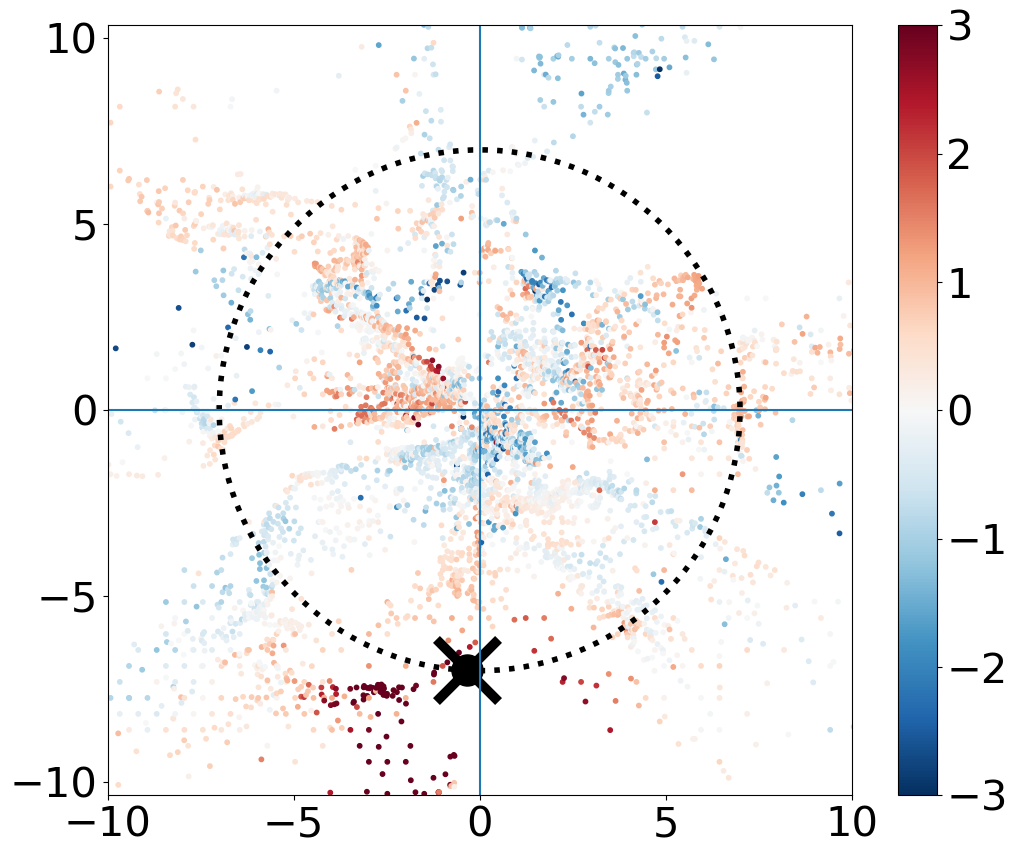

287.94685167496215


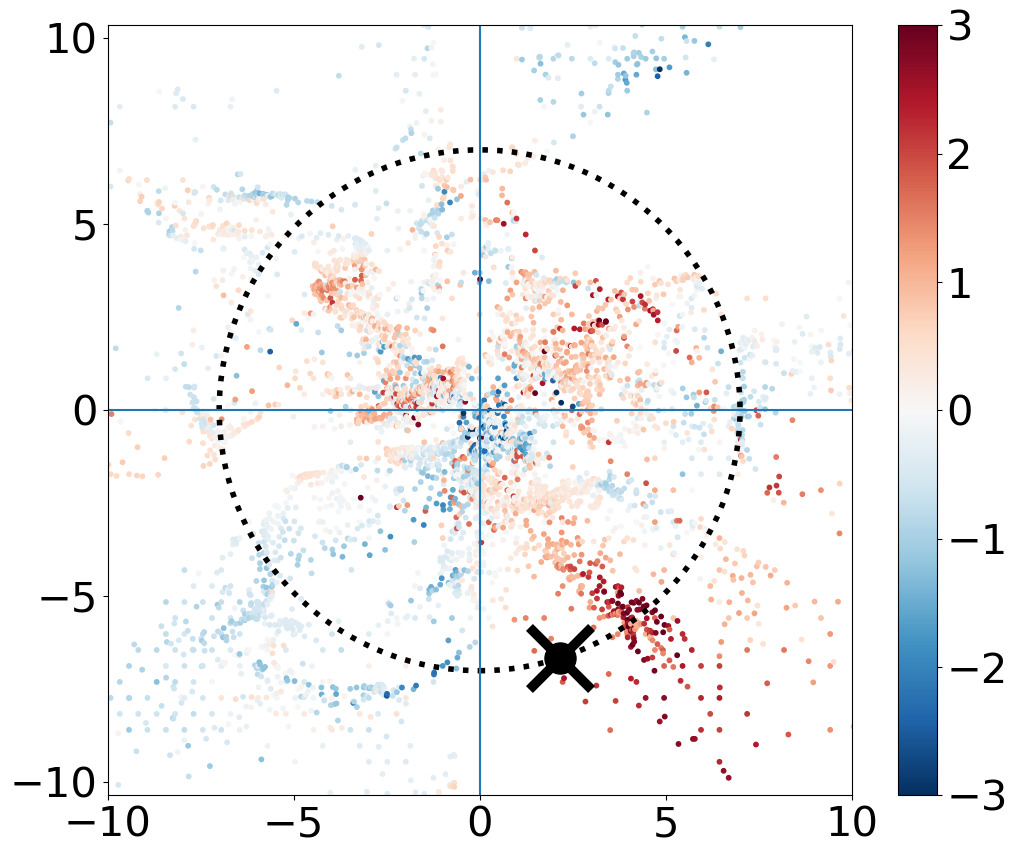

314.73285508037907


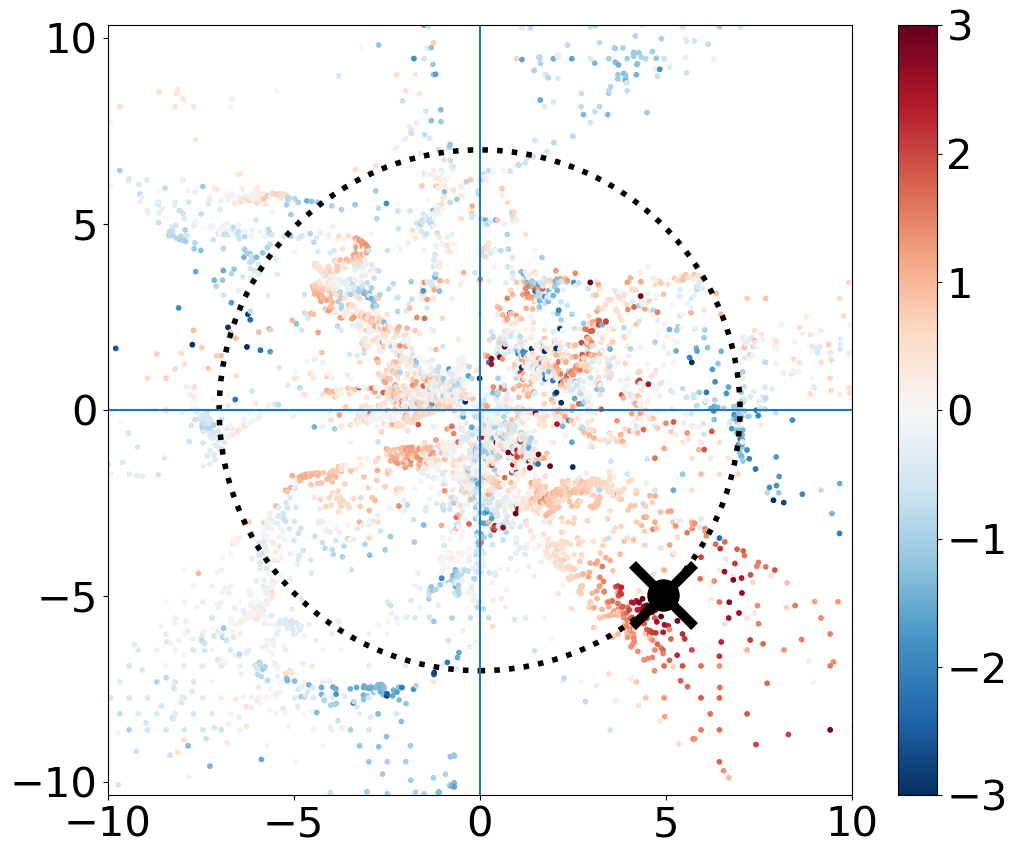

320.38185155657544


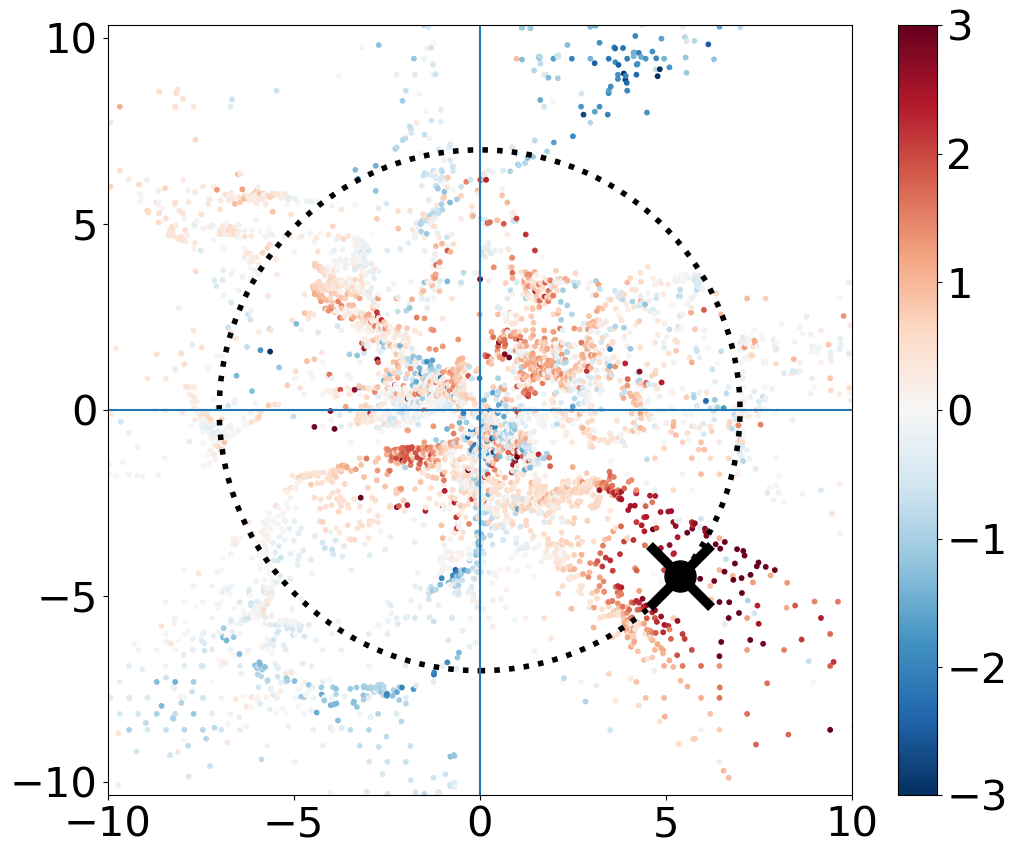

348.8599572678949


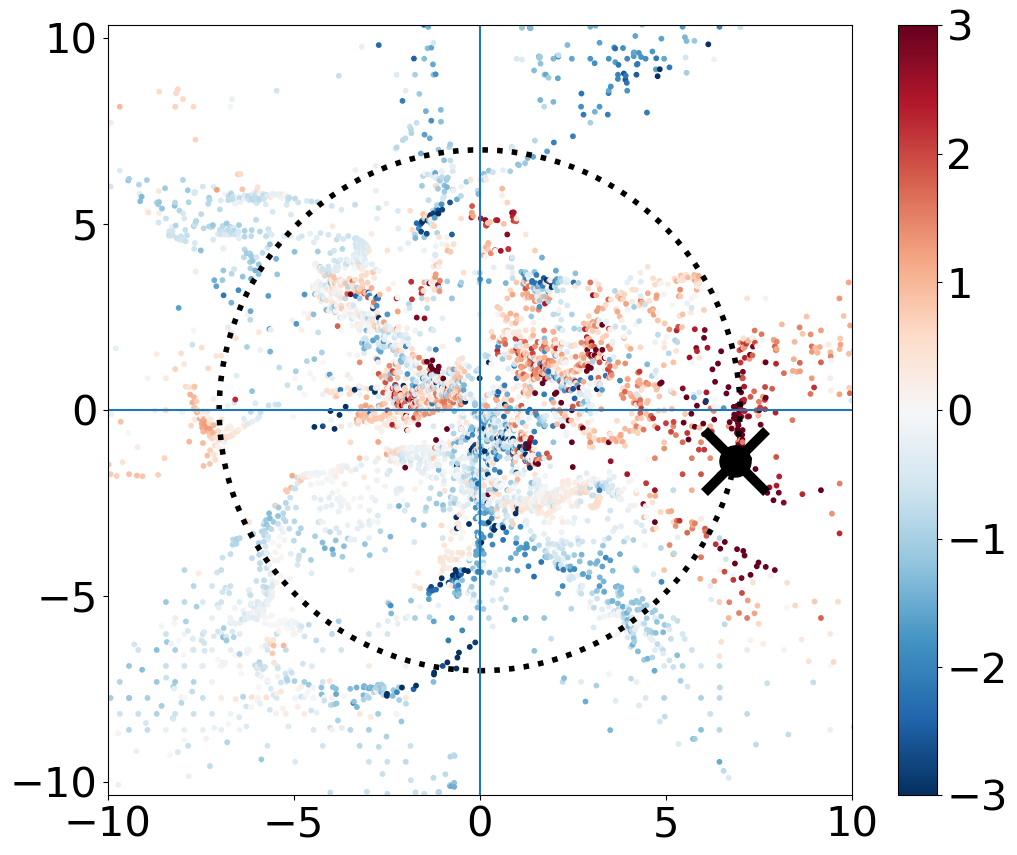

In [123]:
r = 2
t = 'perception'
stim_ecc = 7

df = angdist_df_subj127.query("roi == @r & task == @t")
# df = df[np.abs(stim_ecc - df.eccen) <= df.sigma]
df = df[df.vexpl >= 0.1]
df.beta = (df.beta - np.nanmean(df.beta)) / np.nanstd(df.beta)

for c in df.condition.unique():
    pos = df[df.condition == c]
    pos = pos.groupby(['condition', 'x', 'y'], as_index = False).mean()
    plt.scatter(pos.x, -pos.y, c = pos.beta, alpha = 1, s = 10, cmap = 'RdBu_r', vmin = -3, vmax = 3)
    plt.axis('equal')
    
    x, y = pol2cart(stim_ecc, np.radians(pos.stim_angle.values[0]))
    print(pos.stim_angle.values[0])
    
    circle = plt.Circle((0, 0), radius = stim_ecc, fill = False, lw = 4, linestyle = ":")
    plt.gca().add_patch(circle)
    
    plt.tick_params(which = 'major', labelsize = 30)
    
    plt.scatter(x, y, s = 2000, marker = "x", color = 'black', linewidths = 7)
    plt.scatter(x, y, s = 500, marker = "o", color = 'black')
    
    plt.vlines(0, -12, 12)
    plt.hlines(0, -13, 13)
    
    plt.gcf().set_size_inches([12, 10])
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.yticks([-10, -5, 0, 5, 10])
    
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-3, vmax=3))
    cb = plt.colorbar(sm)
    cb.ax.tick_params(labelsize=30)
    
    plt.show()
    
    

### Panel: Target-aligned average in visual space

Load example subject's data.

In [124]:
angdist_df_subj136 = pd.read_csv(os.path.join(df_dir, 'subj136_angdist_df.tsv'), sep = '\t', index_col = 1)

Use custom functions found in interstellar.py to rotate, interpolate, and average estimates in visual space. For example subject 136

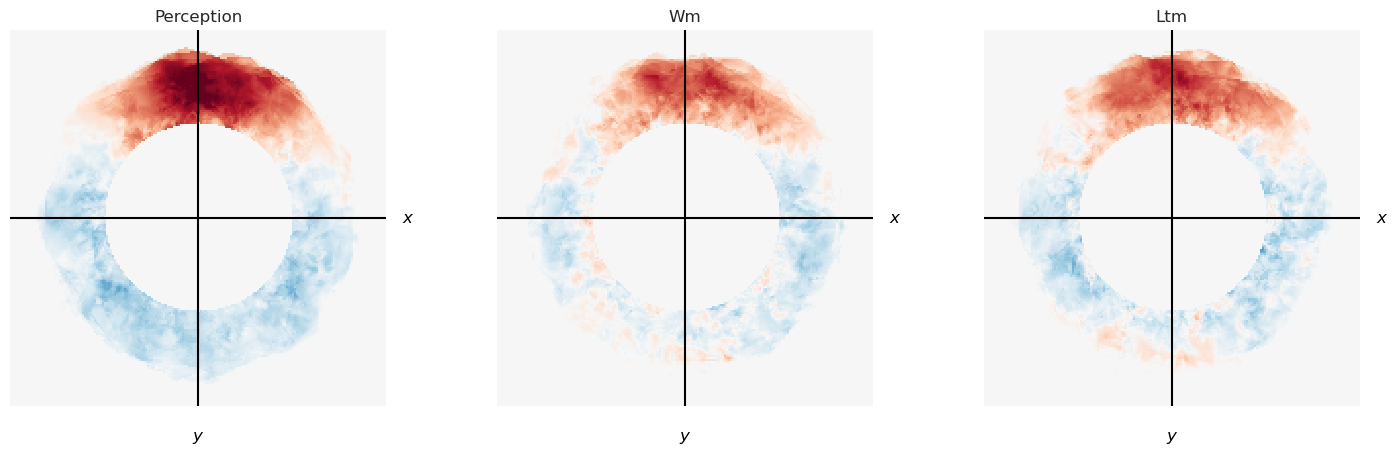

In [131]:
degs_lim = 12
interp_df = []
rot_data = []
roi = 3

for task in angdist_df_subj136.task.unique():
    df = angdist_df_subj136[angdist_df_subj136.task == task]

    for c in df.condition.unique():
        data = df[df.roi == roi]
        data = data[data.condition == c]
        data = data[np.abs(data.eccen - 7) <= data.sigma]
        data = data[data.vexpl >= 0.1]
        # data.beta = data.beta * data.vexpl
        idf, rd = interpolate_activity(data, normalize=True, offset = 90)
        interp_df.append(idf)
        rot_data.append(rd)

v1 = pd.concat(interp_df).reset_index(drop=True)
v1.activity_map_rot[np.isnan(v1.activity_map_rot)] = 0
v1_rot = pd.concat(rot_data).reset_index(drop=True)
ax_data = avg_activity_figure(v1, vmax = 2, degs_lim = degs_lim, stim_radius = 7, 
                              tasks = ['perception', 'wm', 'ltm'], colors = ['b', 'g', 'orange'], eccen_restrict=6)
plt.gcf().set_size_inches([15, 5])
